# 1. Discretize the state space

In [271]:
import numpy as np
from LSTM import LSTM
from System import Plant
from Policy import Estimator
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
np.random.seed(0)

c_resolution = 1 #unit: kW 
p_resolation = 1 #unit: kW
l_resolution = 0.5 #unit: kW
u_resolution = 1 # TODO
dt = 1/30 # hour
T  = 360

c_dis = np.arange(start=0, stop=7.01, step=c_resolution) # TODO kW`h should has larger resolution
p_dis = np.arange(start=0, stop=15.01, step=p_resolation) 
l_dis = np.arange(start=0, stop=10.01, step=l_resolution)
u_dis = np.arange(start=-5, stop=4, step=u_resolution)

n = c_dis.shape[0] * p_dis.shape[0] * l_dis.shape[0]
print("Size of state space: {}".format(n))
print("Size of action space: {}".format(u_dis.shape[0]))

Size of state space: 2688
Size of action space: 9


# 2. Generate transition matrix

In [272]:
def close_idx(list, target):
    '''
    find closest index in list to target
    '''
    return np.argmin(np.abs(list - target))

def get_idx(p_idx, c_idx, l_idx):
    '''
    encode p_idx, c_idx, l_idx to a single integer
    '''
    return int(p_idx * c_dis.shape[0] * l_dis.shape[0] + 
            c_idx * l_dis.shape[0]                  +
            l_idx)
    
def get_pcl(idx):
    '''
    decode p_idx, c_idx, l_idx from a single integer
    '''
    p_idx = idx // (c_dis.shape[0] * l_dis.shape[0])
    c_idx = (idx % (c_dis.shape[0] * l_dis.shape[0])) // l_dis.shape[0]
    l_idx = idx % l_dis.shape[0]
    return [p_dis[p_idx], c_dis[c_idx], l_dis[l_idx]]

def get_convex_combination(p, c, l):
    """Get convex combination given target state

    Returns:
        dict: dictionary of hit state and probability
    """
    
    hit_state_idx_list = {}
    
    def idx_prob(dis, p):
        p_close_idx = close_idx(dis, p)
        if p >= dis[-1]:
            p_left_idx = dis.shape[0] - 1
            p_right_idx = dis.shape[0] - 2
            p_left_prob = 1
            p_right_prob = 0
        elif p <= 0:
            p_left_idx = 0
            p_right_idx = 1
            p_left_prob = 1
            p_right_prob = 0
        elif p >= dis[p_close_idx]:
            p_left_idx = p_close_idx
            p_right_idx = p_close_idx + 1
            p_right_prob = (p - dis[p_close_idx]) / (dis[p_close_idx + 1] - dis[p_close_idx])
            p_left_prob = (dis[p_close_idx + 1] - p) / (dis[p_close_idx + 1] - dis[p_close_idx])
        elif p < dis[p_close_idx]:
            p_left_idx = p_close_idx - 1
            p_right_idx = p_close_idx
            p_right_prob = (p - dis[p_close_idx - 1]) / (dis[p_close_idx] - dis[p_close_idx - 1])
            p_left_prob = (dis[p_close_idx] - p) / (dis[p_close_idx] - dis[p_close_idx - 1])
        return [p_left_idx, p_right_idx, p_left_prob, p_right_prob]
    
    p_idx = np.zeros(2)
    p_prob = np.zeros(2)
    c_idx = np.zeros(2)
    c_prob = np.zeros(2)
    l_idx = np.zeros(2)
    l_prob = np.zeros(2)
    
    p_idx[0], p_idx[1], p_prob[0], p_prob[1] = idx_prob(p_dis, p)
    c_idx[0], c_idx[1], c_prob[0], c_prob[1] = idx_prob(c_dis, c)
    l_idx[0], l_idx[1], l_prob[0], l_prob[1] = idx_prob(l_dis, l)
    
    for i in range(2):
        for j in range(2):
            for k in range(2):
                hit_idx = get_idx(p_idx[i], c_idx[j], l_idx[k])
                hit_prob = p_prob[i] * c_prob[j] * l_prob[k]
                hit_state_idx_list[hit_idx] = hit_prob
    
    return hit_state_idx_list
    

In [273]:
n_sample = 50 #number of monte carlo samples
std = 0.1 # variation of estimated load

P_trans = {}
plant = Plant(dt=dt)
estimator = Estimator()

for l_idx, l in enumerate(l_dis):
    # l_hat = estimator.estimate(l)
    l_hat = l
    l_hats = np.random.normal(loc=l_hat, scale=std, size=n_sample)
    for p_idx, p in enumerate(tqdm(p_dis)):
        for c_idx, c in enumerate(c_dis):
            for u_idx, u in enumerate(u_dis):
                for l_hat in l_hats:
                    state_idx = get_idx(p_idx, c_idx, l_idx)
                    plant.reset(c, p, l)
                    plant.step(u, l_hat)
                    
                    ## get closest state
                    # hit_state_idx = get_idx(close_idx(p_dis, plant.p),
                    #                         close_idx(c_dis, plant.battery.c),
                    #                         close_idx(l_dis, plant.l))
                    # if P_trans.__contains__((state_idx, u_idx, hit_state_idx)):
                    #     P_trans[state_idx, u_idx, hit_state_idx] += (1/n_sample)
                    # else:
                    #     P_trans[state_idx, u_idx, hit_state_idx] = (1/n_sample)
                    
                    ## get cvx combination
                    hit_state_idx_list = get_convex_combination(plant.p, plant.battery.c, plant.l)
                    for hit_state_idx, hit_prob in hit_state_idx_list.items():
                        if P_trans.__contains__((state_idx, u_idx, hit_state_idx)):
                            P_trans[state_idx, u_idx, hit_state_idx] += (1/n_sample) * hit_prob
                        else:
                            P_trans[state_idx, u_idx, hit_state_idx] = (1/n_sample) * hit_prob

100%|██████████| 16/16 [00:03<00:00,  4.88it/s]


Save P_trans dic (super large, takes much time):

In [274]:
# import pickle
# P_trans_file = open("data/P_trans.pkl", "wb")
# pickle.dump(P_trans, P_trans_file)
# P_trans_file.close()

# with open('data/P_trans.pkl', 'rb') as f:
#     P_trans = pickle.load(f)

Ensure the transition matrix is valid:

In [275]:
state_idx = 1000
u_idx = 5

sum = 0
for j in range(n):
    if P_trans.__contains__((state_idx, u_idx, j)):
        sum += P_trans[state_idx, u_idx, j]

print(sum)

1.0000000000000002


# 3. Dynamic programming

In [276]:
import torch
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

P_trans_tensor = torch.sparse_coo_tensor(indices=list(zip(*P_trans.keys())), values=list(P_trans.values()), size=(n, u_dis.shape[0], n), device=device, dtype=torch.float)
T  = 180
J = torch.tensor([get_pcl(i)[0] for i in range(n)], device=device).float()
Actions = torch.zeros(size=(T, n), device=device)

print(J)    
for t in range(T-1, 0, -1):
    J_update = torch.zeros_like(J, device=device)
    for i in tqdm(range(n)): 
        J_update[i], Actions[t][i] = torch.min(P_trans_tensor[i] @ J, dim=0)
    J = J_update
print(J[:10])

tensor([ 0.,  0.,  0.,  ..., 15., 15., 15.], device='cuda:0')


100%|██████████| 2688/2688 [00:01<00:00, 2360.83it/s]

tensor([2.8284, 2.9162, 3.1433, 3.3056, 3.5565, 3.9377, 4.2736, 4.7819, 5.3590,
        5.8909], device='cuda:0')


In [277]:
# print(J)
# print(torch.argmin(J))
# get_pcl(147)

In [278]:
# print(Actions.shape)
# import pickle
# P_trans_file = open("data/Action_table.pkl", "wb")
# pickle.dump(Actions, P_trans_file)
# P_trans_file.close()


In [279]:
# import pickle
# with open('data/Action_table.pkl', 'rb') as f:
#     Actions = pickle.load(f)

# 4. Testing with real data

In [280]:
device = 'cpu'
Actions = Actions.to(device=device)

In [281]:
import pandas as pd

df = pd.read_csv('data.csv')  # read df from csv file

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H;%M:%S')
df = df.drop(columns=['Date', 'Time'])
df.set_index('Datetime', inplace=True)

print(df[:5])

                      Load
Datetime                  
2007-10-01 00:00:00  1.324
2007-10-01 00:01:00  1.320
2007-10-01 00:02:00  1.318
2007-10-01 00:03:00  1.320
2007-10-01 00:04:00  1.312


peak: 0, c: 0, load: 0
action: -5
current time: 2007-10-01 01:40:00
peak: 0.23800000000000002, c: 0, load: 0.23800000000000002
action: 1
current time: 2007-10-01 01:42:00
peak: 1.28, c: 0.032, load: 0.28
action: 1
current time: 2007-10-01 01:44:00
peak: 1.282, c: 0.064, load: 0.282
action: 1
current time: 2007-10-01 01:46:00
peak: 1.31, c: 0.096, load: 0.31
action: 1
current time: 2007-10-01 01:48:00
peak: 1.388, c: 0.128, load: 0.38799999999999996
action: 1
current time: 2007-10-01 01:50:00
peak: 1.388, c: 0.16, load: 0.382
action: 1
current time: 2007-10-01 01:52:00
peak: 1.388, c: 0.192, load: 0.37799999999999995
action: 1
current time: 2007-10-01 01:54:00
peak: 1.388, c: 0.224, load: 0.374
action: 1
current time: 2007-10-01 01:56:00
peak: 1.388, c: 0.256, load: 0.37
action: 1
current time: 2007-10-01 01:58:00
peak: 1.388, c: 0.28800000000000003, load: 0.368
action: 1
current time: 2007-10-01 02:00:00
peak: 1.388, c: 0.32000000000000006, load: 0.368
action: 1
current time: 2007-10-0

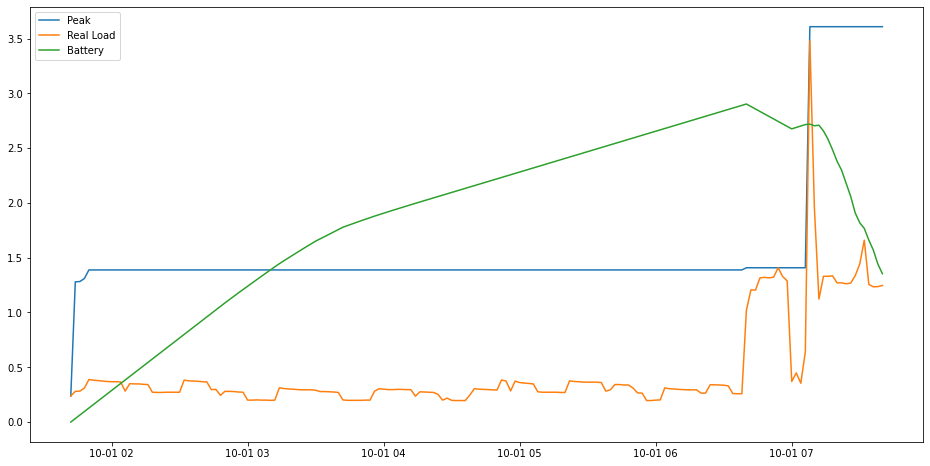

In [286]:
import matplotlib.pyplot as plt
import datetime

simu_time = T * dt # hour
simu_step = T
cur_time = df.index[100] #2007-10-01 00:00:00 

peaks = []
loads = []
times = []
batteries = []

env = Plant(dt=dt)
p, c, l = env.reset(init_battery=0, init_peak=0, init_load=0)
p_pre = p
for i in range(simu_step):
    # state_idx = get_idx(close_idx(p_dis, p), close_idx(c_dis, c), close_idx(l_dis, l))
    # action_idx = int(Actions[i%T][state_idx].item())
    
    hit_state_list = get_convex_combination(p, c, l)
    u = 0
    for state_idx, state_prob in hit_state_list.items():
        action_idx = int(Actions[i%T][int(state_idx)].item())
        u += u_dis[action_idx] * state_prob
    
    print("peak: {}, c: {}, load: {}".format(p, c, l))
    print("action: {}".format(u_dis[action_idx]))
    print("current time:", cur_time)
    print("=============================")
    
    real_load = df.loc[cur_time, 'Load']
    # p, c, l = env.step(u_dis[action_idx], real_load)
    p, c, l = env.step(u, real_load)
    if p == p_pre:
        pass
    
    p_pre = p
    
    cur_time += datetime.timedelta(hours=dt)
    times.append(cur_time)
    # peaks.append(l + u_dis[action_idx])
    peaks.append(p)
    loads.append(l)
    batteries.append(c)

fig, axs = plt.subplots(1, figsize=(16, 8))
axs.plot(times, peaks, label='Peak')
axs.plot(times, loads, label='Real Load')
axs.plot(times, batteries, label='Battery')
axs.legend()
plt.show()